In [3]:
import openpyxl
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import re
import math
import random
from glob import glob
import os

Helper function

In [92]:
def read_result(file):
    data = pd.read_csv(open(file,"r"),delimiter=",",skiprows=0,usecols=[1,2,3])
    all_scores = []
    all_labels = []
    all_predicts = []
    for _, item in data.iterrows():
        all_labels.append(int(item[1] == 'EBV'))
        val = item[2]
#         print(val.split(' ')[0][1:], val.split(' ')[1][:-1])
        scores = [float(re.split(r'\s+', val)[0][1:]), float(re.split(r'\s+', val)[1][:-1])]
        if(scores[0] > 0.2):
            predict = 1
        else:
            predict = 0
        all_scores.append(scores)
        all_predicts.append(predict)

    return np.array(all_scores), np.array(all_labels), np.array(all_predicts)


def get_metrics(all_labels, all_predicts):
    TP = ((all_predicts == 1) & (all_labels == 1)).sum()
    TN = ((all_predicts == 0) & (all_labels == 0)).sum()
    FN = ((all_predicts == 0) & (all_labels == 1)).sum()
    FP = ((all_predicts == 1) & (all_labels == 0)).sum()
    return TP, TN, FN, FP

def get_eer_all_predicts(all_labels, all_scores, T):
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores[:, 1], pos_label=1)
    min_val = 999
    min_i = 0
    for i in range(len(fpr)):
        val = abs(fpr[i] + tpr[i] - 1)
        if val < min_val:
            min_val = val
            min_i = i
    # print(thresholds[min_i], fpr[min_i], tpr[min_i])
    print("threshold[]:", thresholds[min_i])
    all_predicts = []
    for i in range(len(all_labels)):
        if all_scores[i, 1]  >= thresholds[min_i]:
        # if all_scores[i, 1]  >= T:
            all_predicts.append(1)
        else:
            all_predicts.append(0)
        # if all_scores[i, 1]  >= 0.8:
        #     all_predicts.append(1)
        # else:
        #     all_predicts.append(0)
    return np.array(all_predicts)

def bootstrap_auc(all_labels, all_values, n_bootstraps=1000):
    rng_seed = 1  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(all_values), len(all_values))
        if len(np.unique(all_labels[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        score = roc_auc_score(all_labels[indices], all_values[indices])
        bootstrapped_scores.append(score)
#         print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    return bootstrapped_scores


def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    b = stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

def youden(all_labels, all_scores):
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores[:, 1], pos_label=1)
    max_value = 0
    the_value = 0
    the_sensitivity = 0
    the_specificity = 0
    for thresh in thresholds:
        all_predict = []
        for i in range(len(all_scores)):
            if(all_scores[i,1] >= thresh ):
                all_predict.append(1)
            else:
                all_predict.append(0)
        all_predict = np.array(all_predict)
        TP, TN, FN, FP = get_metrics(all_labels, all_predict)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        if((specificity + sensitivity) > max_value):
            max_value = specificity + sensitivity
            the_value = thresh
    return the_value

def plot_roc_curve(fpr, tpr):
    roc_auc = auc(fpr, tpr)  ###计算auc的值

    plt.figure()
    lw = 2
    fig = plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


def print_result(all_labels, all_values, all_predicts):
    TP, TN, FN, FP = get_metrics(all_labels, all_predicts)
#     print(TP, TN, FN, FP)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    fpr, tpr, _ = roc_curve(all_labels, all_values[:, 1], pos_label=1)
    plot_roc_curve(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    all_auc = bootstrap_auc(all_labels, all_values[:,1])
    auc_95_ci = stats.norm.interval(0.95, np.mean(all_auc), np.std(all_auc))
    sen_95_ci = clopper_pearson(TP, TP + FN)
    spe_95_ci = clopper_pearson(TN, FP + TN)
    npv_95_ci = clopper_pearson(TN, TN + FN)
    ppv_95_ci = clopper_pearson(TP, TP + FP)
    print('{:.4f}({:.2f},{:.2f}) {:.4f}({:.2f},{:.2f}) {:.4f}({:.2f},{:.2f}) {:.4f}({:.2f},{:.2f}) {:.4f}({:.2f},{:.2f})'
          .format(sensitivity, sen_95_ci[0], sen_95_ci[1], specificity, spe_95_ci[0], spe_95_ci[1],
                  npv, npv_95_ci[0], npv_95_ci[1], ppv, ppv_95_ci[0], ppv_95_ci[1],
                  roc_auc, auc_95_ci[0], auc_95_ci[1]))
    print("TP:", TP, "           TN:", TN, "            FP:", FP, "            FN:", FN)



Internal data set -each fold

Sensitivity,      Specificity,      NPV,              PPV,              AUC

threshold[]: 0.95814392


<Figure size 432x288 with 0 Axes>

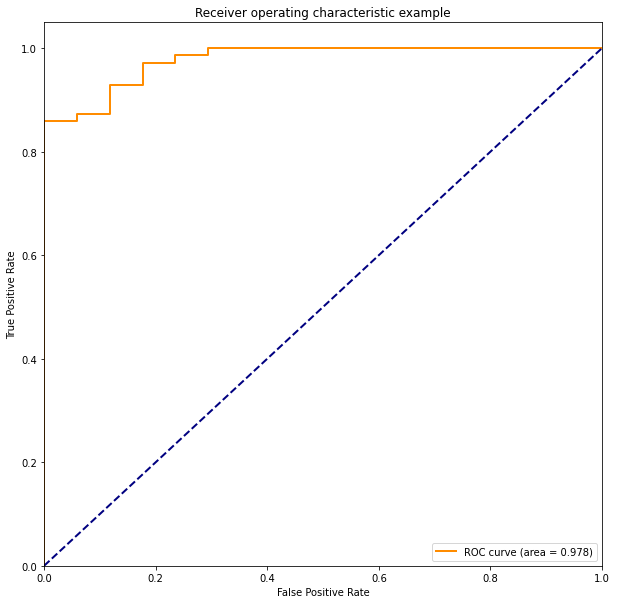

0.8732(0.77,0.94) 0.8824(0.64,0.99) 0.6250(0.41,0.81) 0.9688(0.89,1.00) 0.9776(0.95,1.01)
TP: 62            TN: 15             FP: 2             FN: 9
threshold[]: 0.85954035


<Figure size 432x288 with 0 Axes>

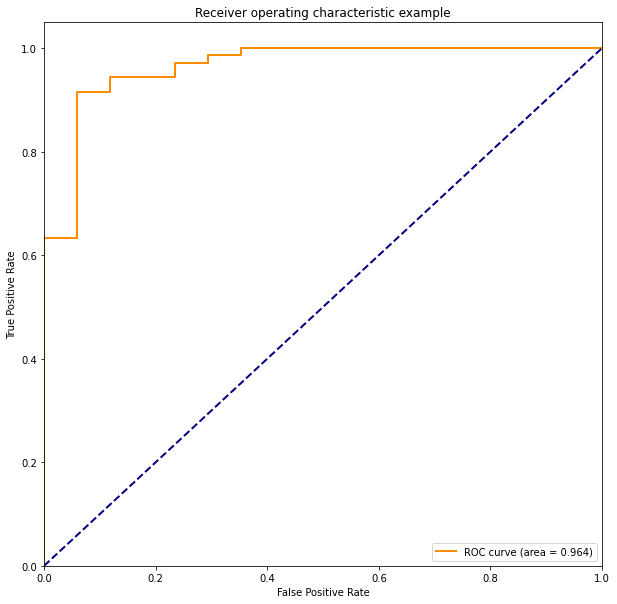

0.9155(0.83,0.97) 0.9412(0.71,1.00) 0.7273(0.50,0.89) 0.9848(0.92,1.00) 0.9644(0.92,1.01)
TP: 65            TN: 16             FP: 1             FN: 6
threshold[]: 0.95500539


<Figure size 432x288 with 0 Axes>

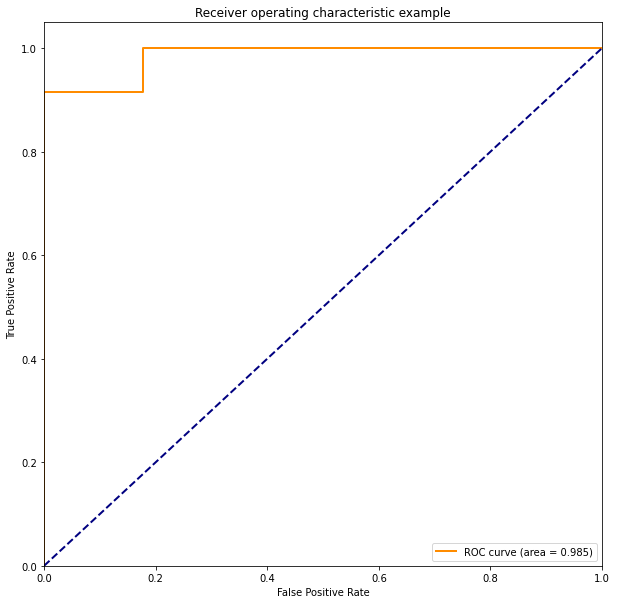

0.9155(0.83,0.97) 1.0000(0.80,1.00) 0.7391(0.52,0.90) 1.0000(0.94,1.00) 0.9851(0.96,1.01)
TP: 65            TN: 17             FP: 0             FN: 6
threshold[]: 0.94024594


<Figure size 432x288 with 0 Axes>

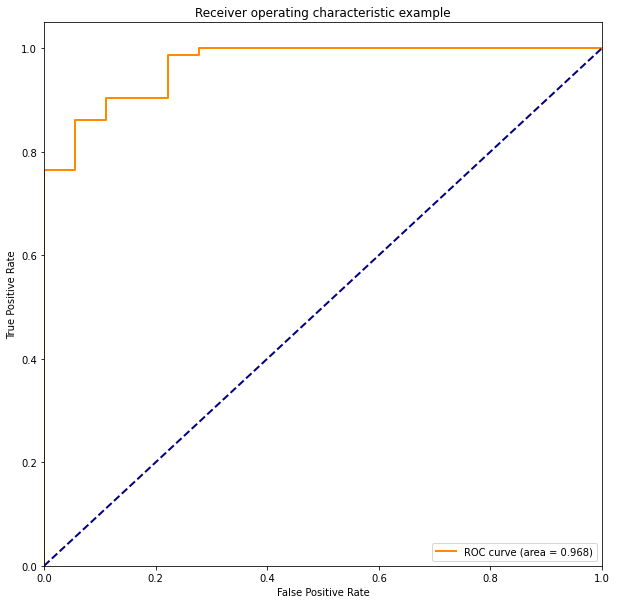

0.9028(0.81,0.96) 0.8889(0.65,0.99) 0.6957(0.47,0.87) 0.9701(0.90,1.00) 0.9676(0.93,1.00)
TP: 65            TN: 16             FP: 2             FN: 7
threshold[]: 0.90394754


<Figure size 432x288 with 0 Axes>

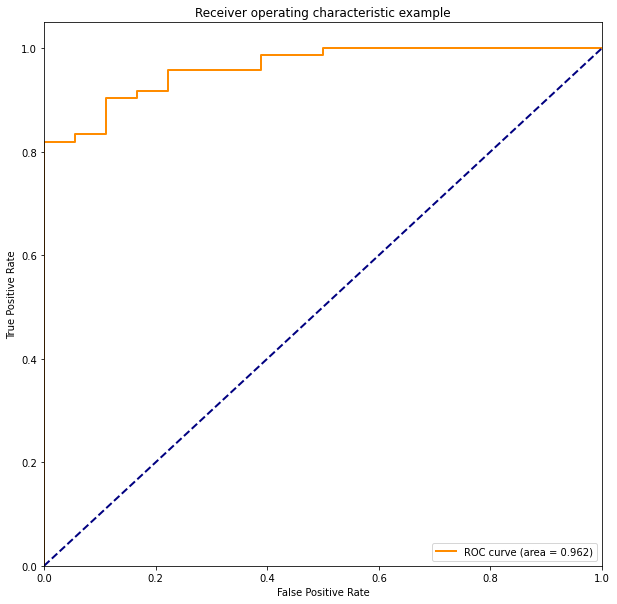

0.9028(0.81,0.96) 0.8889(0.65,0.99) 0.6957(0.47,0.87) 0.9701(0.90,1.00) 0.9622(0.93,1.00)
TP: 65            TN: 16             FP: 2             FN: 7


In [94]:
path = ''
files = []
Range = [1,2,3,4,5]
for i in Range:
    files.append(os.path.join(path, "vgg16_bn_SGD_resample1_fold" + str(i), 'test.csv'))
print('Sensitivity,      Specificity,      NPV,              PPV,              AUC\n')
model_exists = {}
i = 0
for file in files:
    # print(file)
    all_scores, all_labels, all_predicts = read_result(file)
    all_predicts = youden(all_labels, all_scores)
    model_name = file.split('_')[0]
    if model_name not in model_exists:
        # print(model_name + ":")
        model_exists[model_name] = True
    print_result(all_labels, all_scores, all_predicts)